In [52]:
%reload_ext autoreload
%autoreload 2

In [53]:
import pandas as pd
from fastai import *
from fastai.tabular import *
from fastai.callbacks import *
from fastai.text import *
from fastai.data_block import *
from fastai.metrics import *
from sklearn.model_selection import StratifiedKFold
from swallows.training import *
from swallows.models import *
import time
from IPython.display import FileLink, FileLinks
from swallows.plots import *

In [3]:
path=Path('data')

In [4]:
model_name = 'ensemble-v4'

In [5]:
nlp_details_model_name = 'details-60k'
nlp_descr_model_name = 'short_description-60k'
nlp_details_encoder_name = f'{nlp_details_model_name}-tuned-enc'
nlp_descr_encoder_name = f'{nlp_descr_model_name}-tuned-enc'
tab_model_name = f'tab-v4-tuning-3-stage-4-hyper-{30}-{0.001}-{0.2}-fitted'

In [6]:
bs = 256

# Data Packaging

In [7]:
df_train = pd.read_parquet(path/'processed/training_stage_4.parquet', engine='fastparquet')

In [8]:
cont_names = [] # ['create_to_assigned_lag_log']

exclude_from_cats = [
    'ID', 
    'assigned_date',
    'create_date',
    'details',
    'short_description',
    'amazon_domains',
    'root_cause',
    'create_to_assigned_lag'
    'create_to_assigned_lag_log',
    'assigned_date_Elapsed'
    'create_date_Elapsed',
] + cont_names

cat_names = [c for c in df_train.columns if c not in exclude_from_cats]
dep_var = 'root_cause'
procs = [FillMissing, Categorify, Normalize]

In [9]:
large_cats = remove_targets_with_low_frequency(df_train, 'root_cause', min_cat_size=500)

Total cats: 960 with 1156151 items
cats w/ >500 items: 81 with 97.40% coverage


In [10]:
train_data = df_train[df_train['root_cause'].isin(large_cats.reset_index()['root_cause'])]

In [11]:
# splits_idxs = [s for s in gen_splits(10, train_data, 'root_cause')]
# pickle.dump(splits_idxs, open(path/f'{model_name}_cv_splits-10.pkl', "wb"))
splits_idxs = pickle.load(open(path/f'{model_name[:-1]}3_cv_splits-10.pkl', "rb"))
split = splits_idxs[7]

In [12]:
data_details_lm = load_data(path, f'data-lm-{nlp_details_model_name}.pkl', bs=bs)
vocab_details = data_details_lm.vocab

data_descr_lm = load_data(path, f'data-lm-{nlp_descr_model_name}.pkl', bs=bs)
vocab_descr = data_descr_lm.vocab

In [13]:
list_tab = TabularList.from_df(train_data[cat_names + cont_names + [dep_var]], cat_names=cat_names, cont_names=cont_names, procs=procs, path=path)
list_text_details = TextList.from_df(train_data[['details']], cols='details', path=path, vocab=vocab_details)
list_text_descr = TextList.from_df(train_data[['short_description']], cols='short_description', path=path, vocab=vocab_descr)

#### Create mixed databunch

In [14]:
# data_text_descr = (TextList.from_df(train_data[['short_description','root_cause']], cols='short_description', path=path, vocab=vocab_descr)
#                 .split_by_idxs(split[0], split[1])
#                 .label_from_df(cols=dep_var)
#                 .databunch(bs=bs))
# data_text_descr.save(f'{model_name}_data_text_descr')

data_text_descr = load_data(path, f'{model_name}_data_text_descr', bs=bs) # use v3's outputs

In [15]:
# data_text_details = (TextList.from_df(train_data[['details','root_cause']], cols='details', path=path, vocab=vocab_details)
#                 .split_by_idxs(split[0], split[1])
#                 .label_from_df(cols=dep_var)
#                 .databunch(bs=bs))
# data_text_details.save(f'{model_name}_data_text')

data_text_details = load_data(path, f'{model_name[:-1]}3_data_text', bs=bs) # use v3's outputs

In [16]:
# data_tab = (TabularList.from_df(train_data, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
#                            .split_by_idxs(split[0], split[1])
#                            .label_from_df(cols=dep_var)
#                            .databunch(bs=bs))
# data_tab.save(f'{model_name}_data_tab')

data_tab = load_data(path, f'{model_name[:-1]}3_data_tab', bs=bs) # use v3's outputs

In [17]:
data = mixed_data_bunch3(path, data_text_details, data_tab, data_text_descr, bs)

# Training

#### Load models

In [18]:
def build_learner(data):
    nlp_details_model, nlp_det_layer_groups = load_nlp_backbone(data_text_details, nlp_details_encoder_name)
    nlp_descr_model, nlp_dsc_layer_groups = load_nlp_backbone(data_text_descr, nlp_descr_encoder_name)
    tab_model, tab_layer_groups = load_tabular_backbone(data_tab, tab_model_name)
    
    len_nlp_det_out = nlp_details_model[1].layers[2].out_features
    len_nlp_desc_out = nlp_descr_model[1].layers[2].out_features
    len_tab_out = tab_model.layers[4].out_features
    
    lin_layers = [len_nlp_det_out + len_nlp_desc_out + len_tab_out, len(data.classes)]
    model = EnsembleModel3(tab_model, nlp_details_model, nlp_descr_model, lin_layers, drops=[0.2])
    layer_groups = [
                nn.Sequential(*(flatten_model(nlp_det_layer_groups[0]) + flatten_model(nlp_dsc_layer_groups[0]) + flatten_model(tab_layer_groups[0]))),
                nn.Sequential(*(flatten_model(nlp_det_layer_groups[1]) + flatten_model(nlp_dsc_layer_groups[1]))),
                nn.Sequential(*(flatten_model(nlp_det_layer_groups[2]) + flatten_model(nlp_dsc_layer_groups[2]))),
                nn.Sequential(*(flatten_model(nlp_det_layer_groups[3]) + flatten_model(nlp_dsc_layer_groups[3]))),
                nn.Sequential(*(flatten_model(nlp_det_layer_groups[4]) + flatten_model(nlp_dsc_layer_groups[4]))),
                nn.Sequential(*flatten_model(model.layers))]
    
    learn = Learner(data, model, metrics=accuracy_v2, layer_groups=layer_groups)
    return learn

#### Training

In [19]:
learn = build_learner(data)
learn.freeze()

epoch,train_loss,valid_loss,accuracy_v2,time
0,1.237062,1.254822,0.599179,15:12


Better model found at epoch 0 with accuracy_v2 value: 0.5991793274879456.


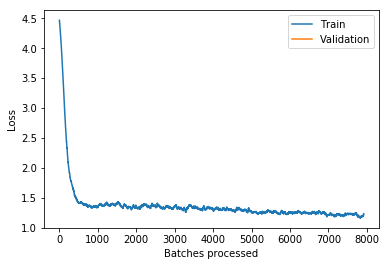

In [21]:
callbacks = SaveModelCallback(learn, every='improvement', mode='max', monitor='accuracy_v2', name=f'{model_name}-1')
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7), callbacks=callbacks); learn.recorder.plot_losses()

In [22]:
learn.freeze_to(-2)

epoch,train_loss,valid_loss,accuracy_v2,time
0,1.248066,1.238515,0.605823,14:25


Better model found at epoch 0 with accuracy_v2 value: 0.6058229207992554.


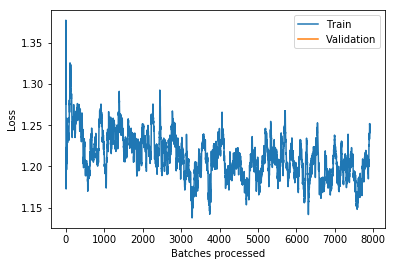

In [23]:
callbacks = SaveModelCallback(learn, every='improvement', mode='max', monitor='accuracy_v2', name=f'{model_name}-2')
learn.fit_one_cycle(1, slice(1e-4/(2.6**4),1e-4), moms=(0.8, 0.7), callbacks=callbacks); learn.recorder.plot_losses()

In [24]:
learn.freeze_to(-3)

epoch,train_loss,valid_loss,accuracy_v2,time
0,1.156581,1.213326,0.614447,15:24


Better model found at epoch 0 with accuracy_v2 value: 0.6144472360610962.


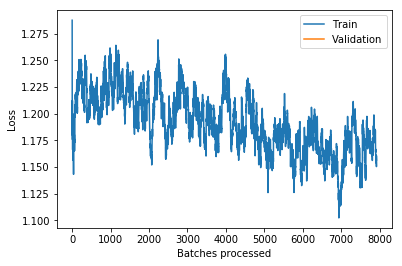

In [25]:
callbacks = SaveModelCallback(learn, every='improvement', mode='max', monitor='accuracy_v2', name=f'{model_name}-3')
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3), moms=(0.8, 0.7), callbacks=callbacks); learn.recorder.plot_losses()

In [26]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_v2,time
0,1.184859,1.201666,0.617671,33:17
1,1.093539,1.181980,0.622654,38:09
2,1.098555,1.184987,0.623134,31:46


Better model found at epoch 0 with accuracy_v2 value: 0.6176713705062866.
Better model found at epoch 1 with accuracy_v2 value: 0.6226540803909302.
Better model found at epoch 2 with accuracy_v2 value: 0.6231337189674377.


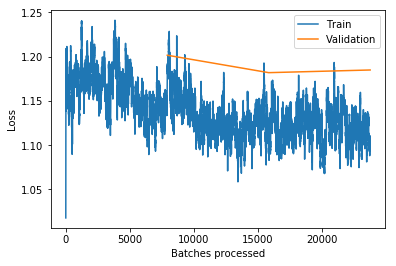

In [27]:
callbacks = SaveModelCallback(learn, every='improvement', mode='max', monitor='accuracy_v2', name=f'{model_name}-fitted')
learn.fit_one_cycle(3, slice(5e-4/(2.6**4),5e-4), moms=(0.8, 0.7), callbacks=callbacks); learn.recorder.plot_losses()

Public leaderboard score: 0.607349433091

# Predict

In [28]:
df_test = pd.read_parquet(path/'processed/public_test_features_stage_4.parquet', engine='fastparquet')
df_test_ids = pd.read_csv(path/'public_test_features_IDs.csv', low_memory=False)

In [30]:
data_text_details.add_test(TextList.from_df(df_test[['details']], path, vocab=vocab_details))
data_text_descr.add_test(TextList.from_df(df_test[['short_description']], path, vocab=vocab_descr))
data_tab.add_test(TabularList.from_df(df_test[cat_names + cont_names], path=path, cat_names=cat_names, cont_names=cont_names))

In [31]:
data_test = mixed_data_bunch3(path, data_text_details, data_tab, data_text_descr, bs)

In [32]:
learn_test = build_learner(data_test)
learn_test.load(f'{model_name}-fitted')

Learner(data=DataBunch;

Train: <swallows.models.EnsembleDataset3 object at 0x7f53aee6d400>;

Valid: <swallows.models.EnsembleDataset3 object at 0x7f53aee6d470>;

Test: <swallows.models.EnsembleDataset3 object at 0x7f53aee6d5f8>, model=EnsembleModel3(
  (tab_model): TabularModel(
    (embeds): ModuleList(
      (0): Embedding(448, 49)
      (1): Embedding(8, 5)
      (2): Embedding(92, 20)
      (3): Embedding(6, 4)
      (4): Embedding(1565, 98)
      (5): Embedding(5, 4)
      (6): Embedding(3, 3)
      (7): Embedding(1028, 78)
      (8): Embedding(2241, 120)
      (9): Embedding(36, 12)
      (10): Embedding(1071, 80)
      (11): Embedding(34, 12)
      (12): Embedding(1869, 109)
      (13): Embedding(6, 4)
      (14): Embedding(311, 40)
      (15): Embedding(517, 53)
      (16): Embedding(34, 12)
      (17): Embedding(3, 3)
      (18): Embedding(3, 3)
      (19): Embedding(3, 3)
      (20): Embedding(3, 3)
      (21): Embedding(3, 3)
      (22): Embedding(3, 3)
      (23): Embeddin

In [33]:
learn_test.validate()

[1.1849874, tensor(0.6231)]

In [34]:
preds,y = learn_test.get_preds(ds_type=DatasetType.Test)

In [35]:
pred_classes = [data_test.classes[cls] for cls in np.argmax(preds.numpy(), axis=1)]

In [36]:
df_out = pd.DataFrame({'ID': df_test_ids['ID'], 'root_cause': pred_classes})

In [37]:
t = time.strftime('%Y_%m_%d_%H_%M')
out_fname = path/f'mle_ops_tech_{t}_{model_name}.csv'
df_out.to_csv(out_fname, index=False)
FileLink(out_fname)

/home/ec2-user/2019-ops-it-challenge/data/mle_ops_tech_2019_05_03_09_35_ensemble-v4.csv

# Interpretation

In [51]:
preds,y = learn_test.get_preds(ds_type=DatasetType.Valid)

In [39]:
pred_classes = [data_test.classes[cls] for cls in np.argmax(preds.numpy(), axis=1)]

In [40]:
actl_classes = [data_test.classes[cls] for cls in y]

In [47]:
df_out_val = df_train.iloc[split[1]].copy()
df_out_val['predicted_root_cause'] = pred_classes

In [49]:
t = time.strftime('%Y_%m_%d_%H_%M')
out_fname = path/f'mle_ops_tech_{t}_{model_name}-val-set.csv'
df_out_val.to_csv(out_fname, index=False)
FileLink(out_fname)

/home/ec2-user/2019-ops-it-challenge/data/mle_ops_tech_2019_05_03_09_47_ensemble-v4-val-set.csv

In [41]:
from sklearn.metrics import confusion_matrix

In [42]:
cnf_matrix = confusion_matrix(y, np.argmax(preds.numpy(), axis=1))

Normalized confusion matrix


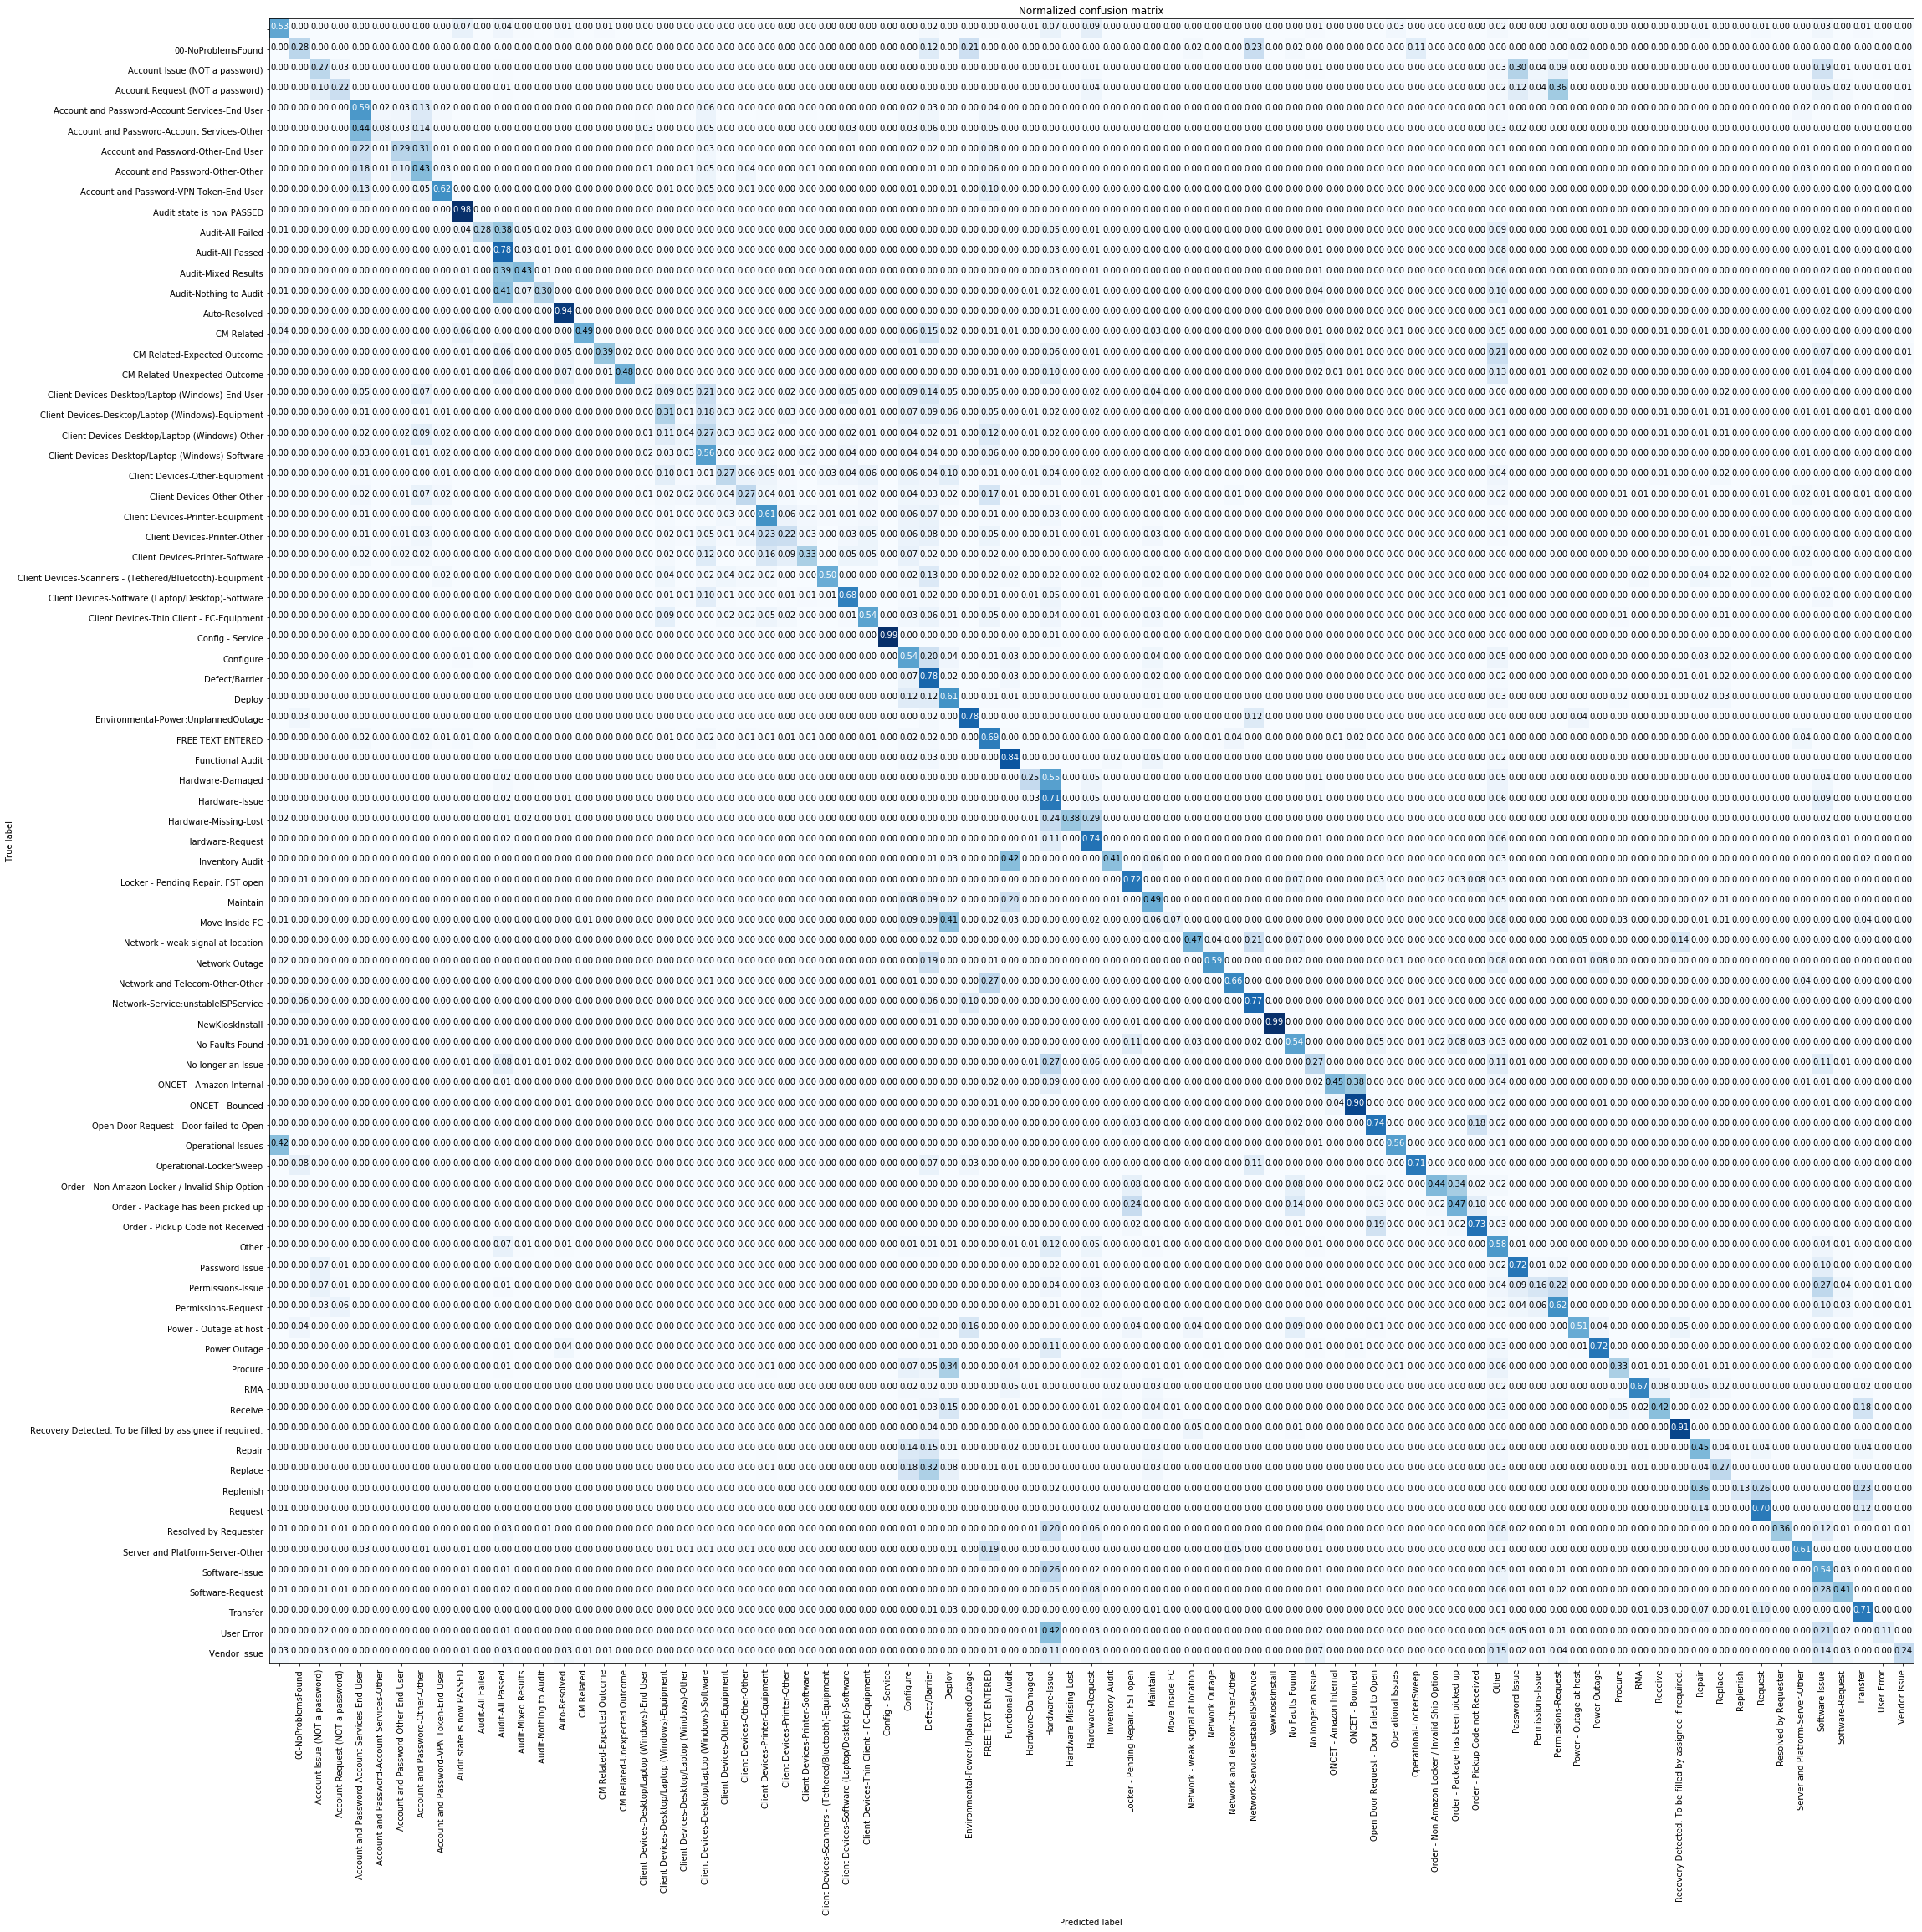

In [43]:
4

Confusion matrix, without normalization


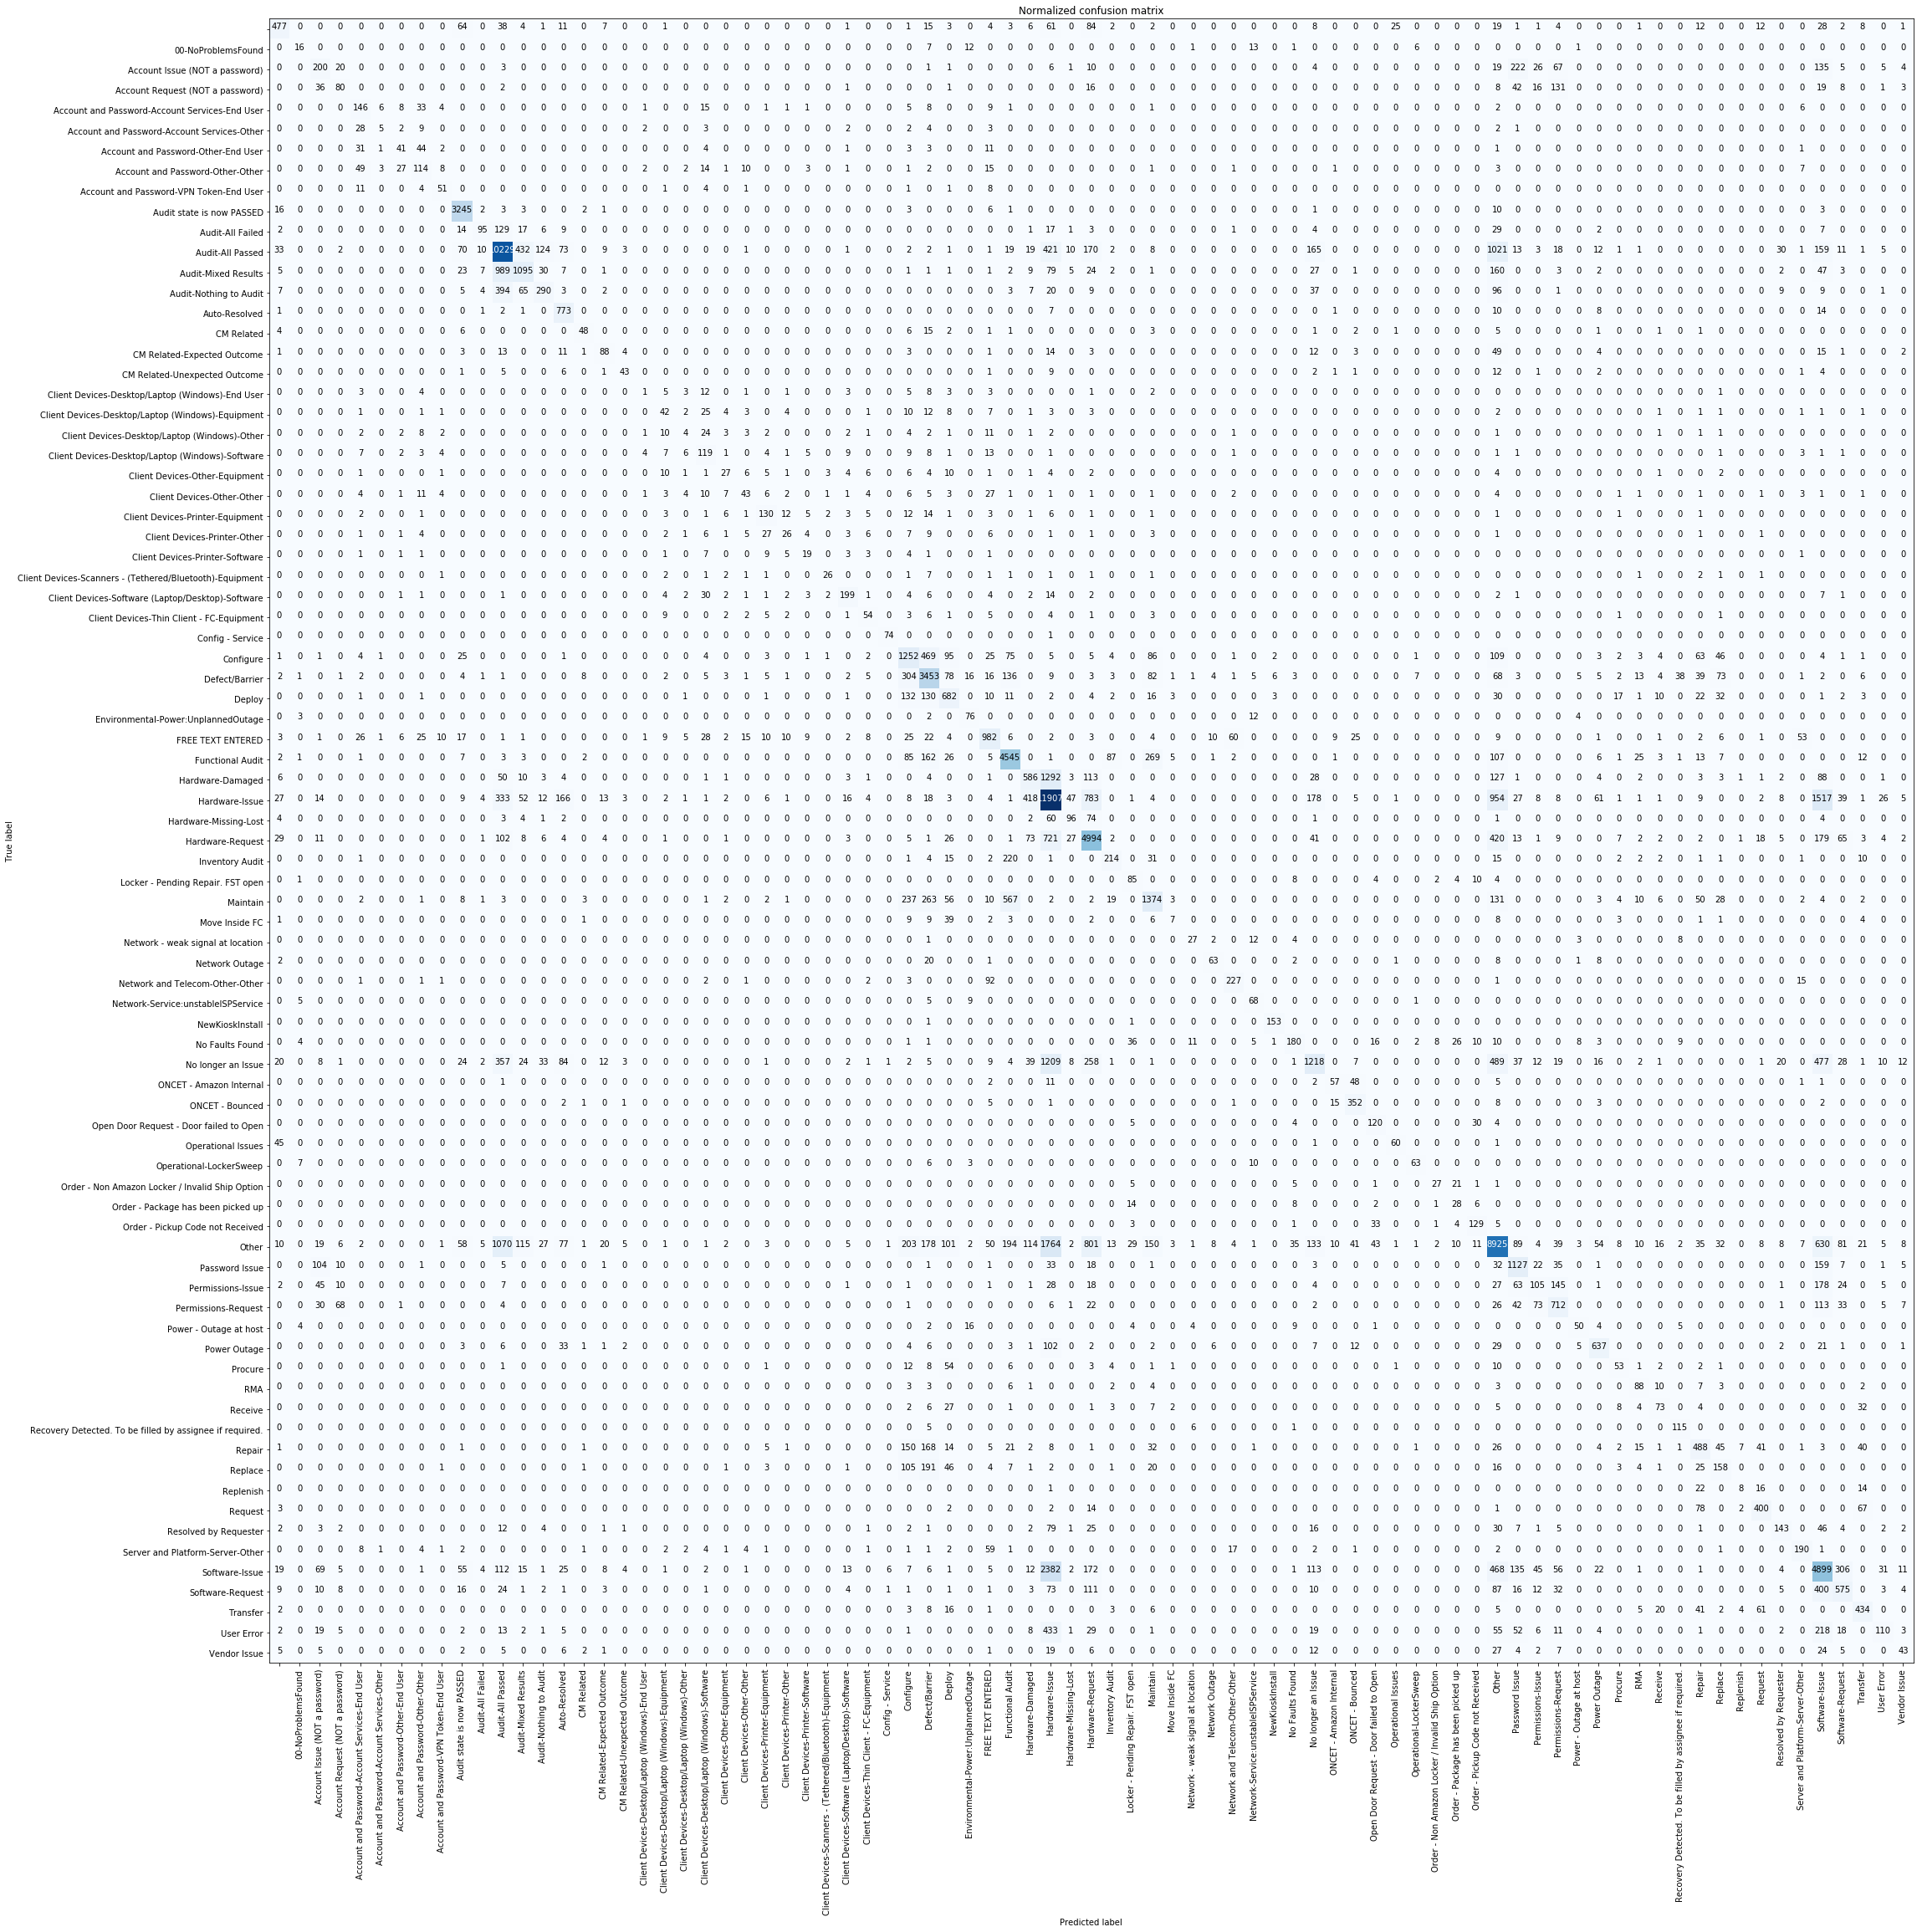

In [44]:
fig = plt.figure()
fig.set_size_inches(32, 32, forward=True)
plot_confusion_matrix(cnf_matrix, classes=data_test.classes, normalize=False, title='Normalized confusion matrix')